In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c carvana-image-masking-challenge

metadata.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_masks.zip: Skipping, found more recently modified local copy (use --force to force download)
train_masks.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
29bb3ece3180_11.jpg: Skipping, found more recently modified local copy (use --force to force download)
train_hq.zip: Skipping, found more recently modified local copy (use --force to force download)
test_hq.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import random
import numpy as np

import os
import pandas as pd
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import imageio

import os
import time
import h5py
import math
import pickle
import cv2

import seaborn as sns
from scipy import misc,ndimage
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage import transform
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
from tensorflow.python.client import device_lib

In [0]:
!ls

 29bb3ece3180_11.jpg
'kaggle (1).json'
 kaggle.json
 metadata.csv
 metadata.csv.zip
 model-1546239658-weights.h5
 model-1546243541.h5
 model-1546243541.history
 model-1546243541-weights.h5
'model=trial-batch_size=2-num_epoch=2-steps_per_epoch=2035-ts=1546243541'
'model=trial-batch_size=2-num_epoch=5-steps_per_epoch=2035-ts=1546239658'
 sample_data
 sample_submission.csv
 sample_submission.csv.zip
 test
 test_hq
 test_hq.zip
 test.zip
 train
 train_hq
 train_hq.zip
 train_masks
 train_masks.csv
 train_masks.csv.zip
 train_masks.zip
 train.zip


In [0]:
files = os.listdir('./')
print(files)

['.config', 'train_masks.csv.zip', 'kaggle.json', 'train_hq', 'model-1546243541.history', 'train_hq.zip', 'train', 'test_hq', 'model-1546243541-weights.h5', 'kaggle (1).json', 'metadata.csv', 'train.zip', 'train_masks.zip', 'test.zip', 'model=trial-batch_size=2-num_epoch=2-steps_per_epoch=2035-ts=1546243541', 'metadata.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv', 'model-1546239658-weights.h5', 'train_masks.csv', 'train_masks', 'model-1546243541.h5', 'model=trial-batch_size=2-num_epoch=5-steps_per_epoch=2035-ts=1546239658', 'test', '29bb3ece3180_11.jpg', 'test_hq.zip', 'sample_data']


In [0]:
import zipfile
for i in files:
  if 'train' in files:
    break
  if '.zip' in i:
    print(i)
    with zipfile.ZipFile('./'+i, 'r') as zip_ref:
      zip_ref.extractall('./')

In [0]:
!ls

 29bb3ece3180_11.jpg
'kaggle (1).json'
 kaggle.json
 metadata.csv
 metadata.csv.zip
 model-1546239658-weights.h5
 model-1546243541.h5
 model-1546243541.history
 model-1546243541-weights.h5
'model=trial-batch_size=2-num_epoch=2-steps_per_epoch=2035-ts=1546243541'
'model=trial-batch_size=2-num_epoch=5-steps_per_epoch=2035-ts=1546239658'
 sample_data
 sample_submission.csv
 sample_submission.csv.zip
 test
 test_hq
 test_hq.zip
 test.zip
 train
 train_hq
 train_hq.zip
 train_masks
 train_masks.csv
 train_masks.csv.zip
 train_masks.zip
 train.zip


In [0]:
DATA_PATH = './'
RAW_DATA_PATH = os.path.join(DATA_PATH, '')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')

In [0]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
train_masks_df.shape

(5088, 2)

In [0]:
def plot_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id):
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    imgplot = plt.imshow(mask)
    plt.axis('off')
    plt.show()
    
def plot_masked_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    temp = mask.copy()
    temp[temp == 255] = 1 
    masked_img = img * temp
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

Car id 6d21aad248e4_07


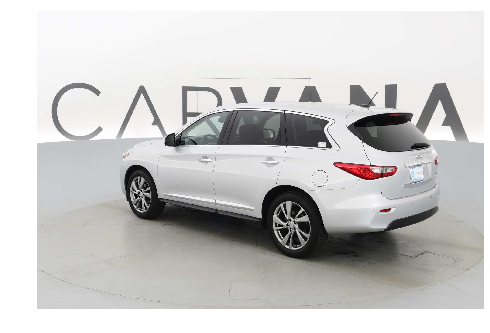

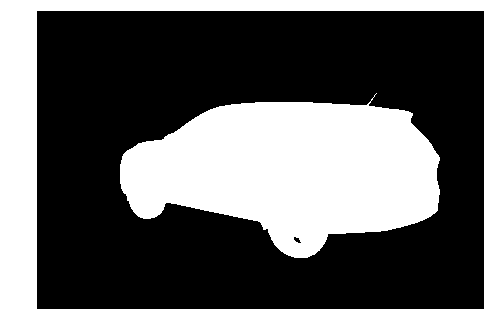

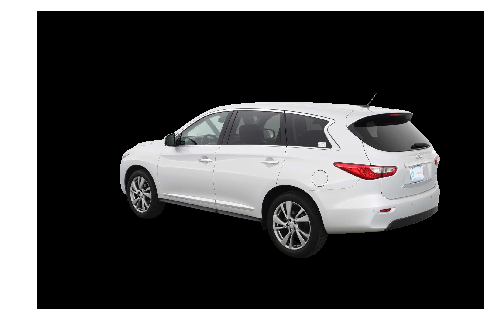

In [0]:
# Plot random car, mask, masked_car
random_car_idx = int(np.random.random() * len(train_masks_df))
random_img_path = train_masks_df.iloc[random_car_idx].values[0]
m = re.match(r'([a-f0-9].*).jpg', random_img_path)
random_img_id = m.group(1)
print('Car id {}'.format(random_img_id))
plot_image(random_img_id)
plot_mask(random_img_id)
plot_masked_image(random_img_id)

In [0]:
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)
print('sample_submission_df.shape', sample_submission_df.shape)
sample_submission_df.head()

sample_submission_df.shape (100064, 2)


,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [0]:
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy
import keras.backend.tensorflow_backend as KTF
def simple_model():
    inputs = Input(shape=(2,2,2))
    x = UpSampling2D((1,2))(inputs)
    #x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    model = Model(inputs=inputs, outputs=x)
    return model

model = simple_model()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 2, 2, 2)           0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 2, 4, 2)           0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Constants
HEIGHT_ORIG = 1280
WIDTH_ORIG = 1918
CHANNELS_ORIG = 3

SEED_VAL = 42

HEIGHT = 512
WIDTH = 512
CHANNELS = 3
new_shape = (HEIGHT, WIDTH, CHANNELS)
mask_shape = (new_shape[0], new_shape[1], 1)

In [0]:
metadata_df = pd.read_csv(METADATA_PATH)
print('metadata_df.shape', metadata_df.shape)

metadata_df.shape (6572, 6)


In [0]:
np.random.seed(SEED_VAL)
choice = np.random.choice(len(train_masks_df), 20)
train_masks_df.iloc[choice,:]

,img,rle_mask
860,2af7c265531e_13.jpg,677880 77 679780 115 681683 144 683589 168 685...
3772,c2fd64144e97_13.jpg,430227 1 432146 1 434064 2 435983 2 437902 2 4...
3092,9274d0b3caa8_05.jpg,889118 93 891000 171 892898 213 894801 242 896...
466,189a2a32a615_03.jpg,586204 2 588121 3 590039 2 591957 2 593874 3 5...
4426,de74550a306a_11.jpg,610573 1 612490 4 614409 4 616327 5 618246 5 6...
3444,ad5a6a058944_05.jpg,921589 49 923483 98 925386 129 927292 155 9292...
3171,9ab2a45de8c7_04.jpg,755004 6 756915 20 758829 25 760745 28 762661 ...
2919,888e04d96663_08.jpg,626336 1 628254 1 630171 1 632089 1 634006 2 6...
130,0cdf5b5d0ce1_03.jpg,616821 1 618737 3 620655 3 622572 4 624489 5 6...
1685,4dc8a7fe7c02_06.jpg,544187 1 546103 3 548020 3 549937 3 551854 3 5...


In [0]:
def get_img(img_id):
    return mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
       
def get_mask_inner(img_id, num_channels=-1):
    if num_channels!=-1:
        mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"), flatten=True)
        mask[mask > 128] = 1
        if len(mask.shape) == 2:
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        return mask
    else:
        mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
        mask = mask[:,:,0:3]
        return mask

def resize_img(img, new_s = new_shape):
    return transform.resize(img, new_s)

def load_imgs(img_id, folder=TRAIN_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".jpg"))
    return img

def gray2rgb(img):
    img = np.squeeze(img)
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

In [0]:
def check_mask(mask_id):
    print("mask id:", mask_id)
    plot_mask(mask_id)
    img = get_img(mask_id)
    mask = get_mask_inner(mask_id, 1)
    masked_img = img * mask
#     print('mask:', mask.shape) 
#     print('img:', img.shape)
#     imgplot = plt.imshow(masked_img)
#     plt.axis('off')
#     plt.show()
    mask = get_mask_inner(mask_id, -1)
    threshold = 127
    imgray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, threshold, 255,0)
    im2, contours, hierachy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    im = cv2.drawContours(imgray, contours, -1, (255,255,255), 3)
    imgplot = plt.imshow(im)
    plt.axis('off')
    plt.show()

mask id: 00087a6bd4dc_01


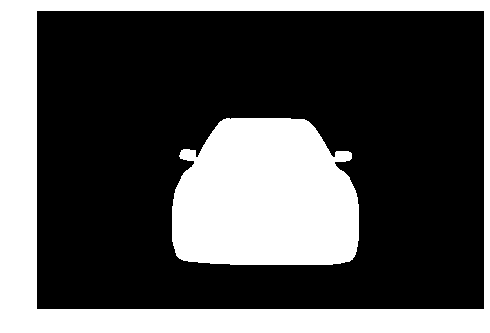

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


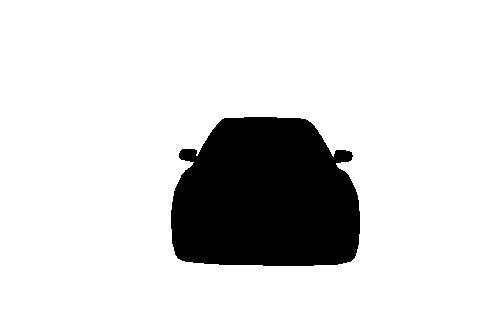

mask id: 8d1a6723c458_01


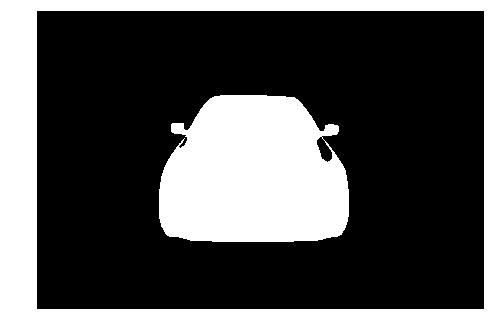

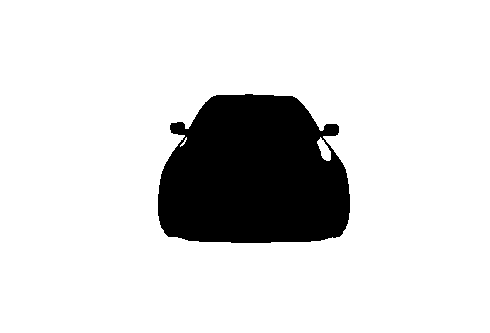

In [0]:
check_mask(train_masks_df.iloc[0,0][0:-4])
check_mask('8d1a6723c458_01')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


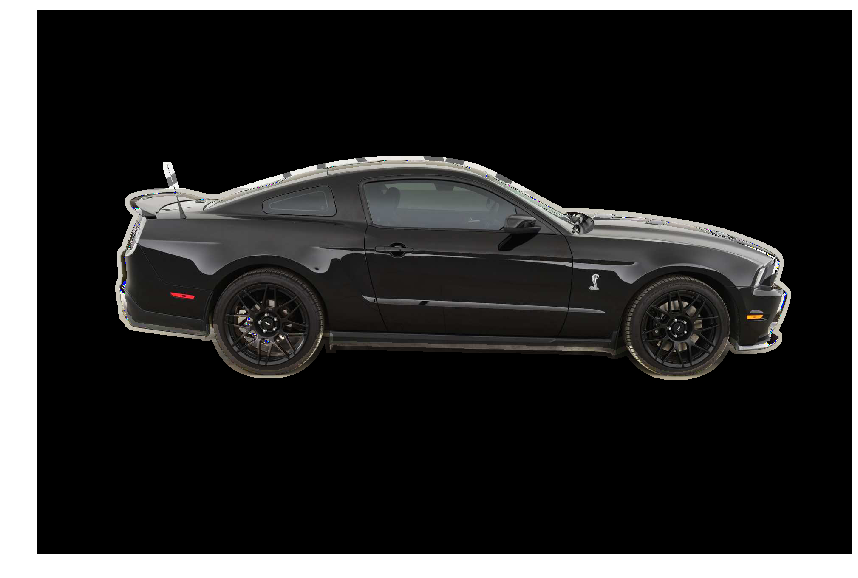

In [0]:
_id = '2af7c265531e_13'

orig_mask = get_mask_inner(_id,1)
orig_mask = np.squeeze(orig_mask)
orig_mask.shape
img = get_img(_id)
def get_model():
    inputs = Input(shape=(1280, 1918, 1))
    #averaged_mask = Conv2D(1, (1, 1), padding='same')(inputs)
    averaged_mask = AveragePooling2D(pool_size=(20, 20), strides=1, padding='same')(inputs)
    model = Model(inputs=inputs, outputs=averaged_mask)
    return model
    
model= get_model()
pred_mask = model.predict(np.expand_dims(get_mask_inner(_id,1),0))

border = (pred_mask>0.01) * (pred_mask< 0.99)
border.astype('float64')
border = np.squeeze(border)

border = border + orig_mask
masked_img = img * gray2rgb(border)

plt.figure(figsize=(20,10))
plt.imshow(masked_img)
plt.axis('off')
plt.show()

id: 36a3f7f77e85_01


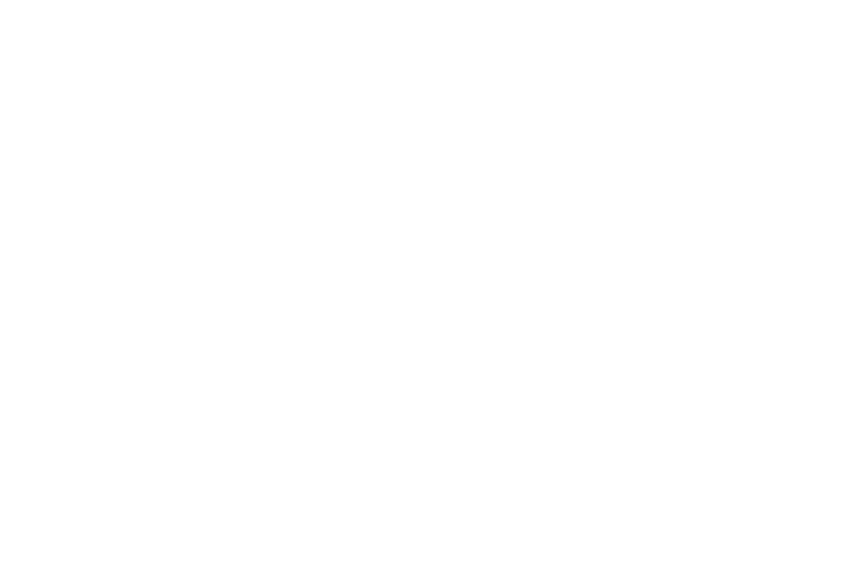

id: 36a3f7f77e85_02


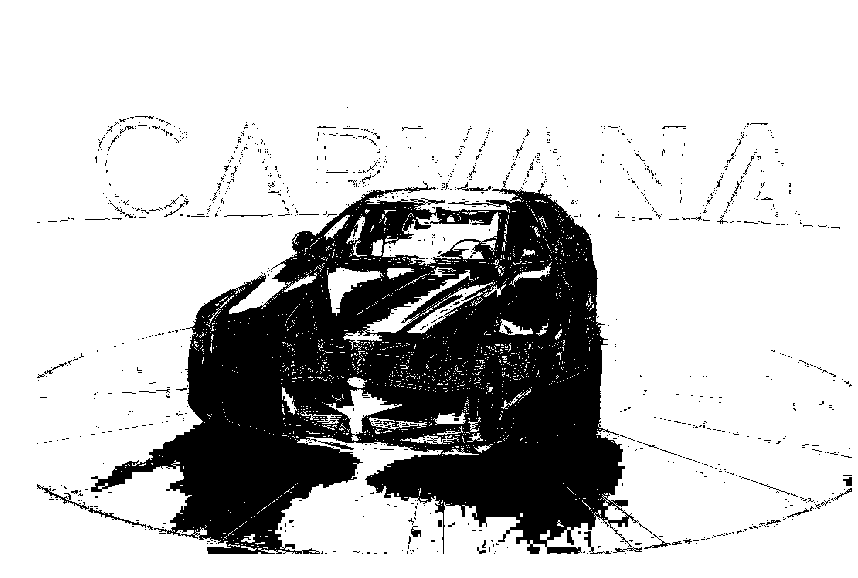

id: 36a3f7f77e85_03


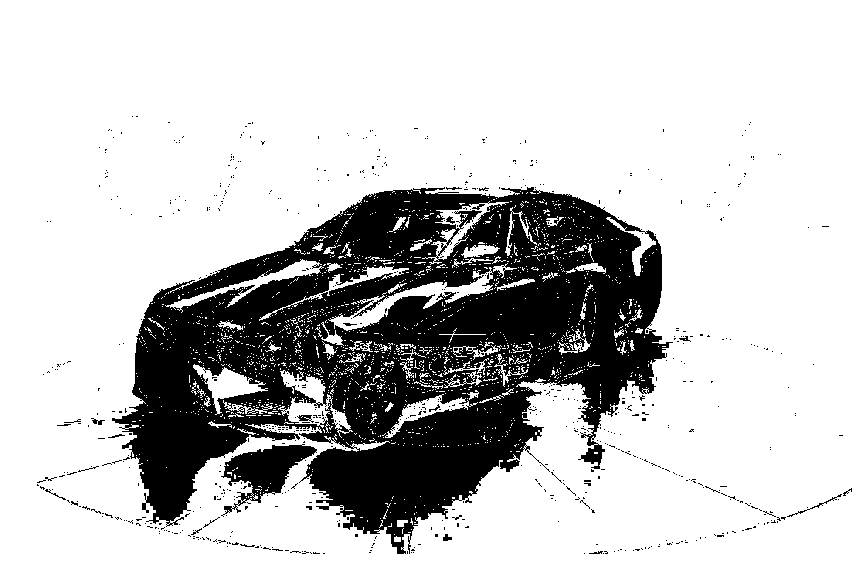

id: 36a3f7f77e85_04


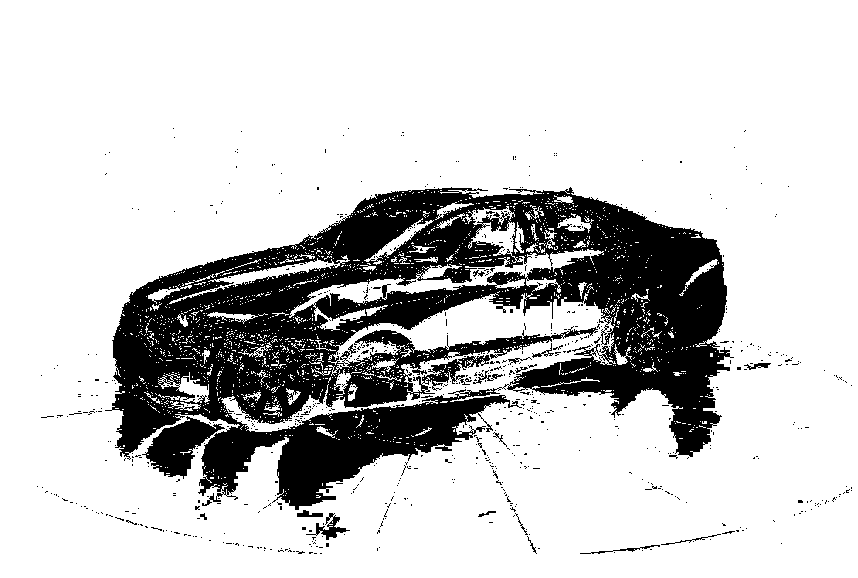

id: 36a3f7f77e85_05


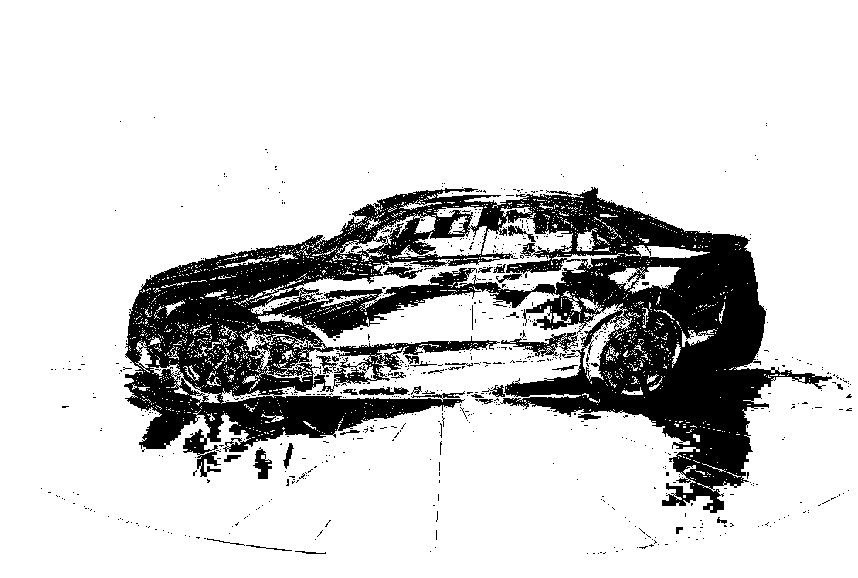

id: 36a3f7f77e85_06


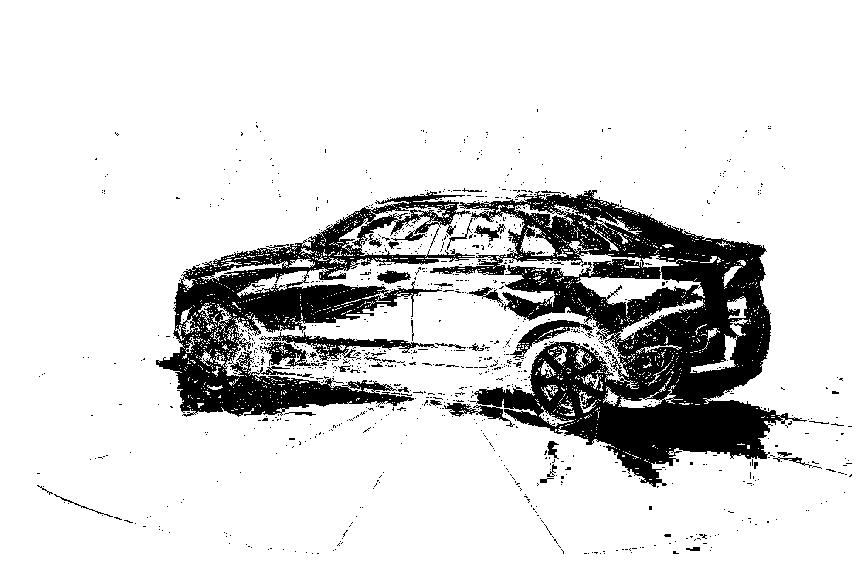

id: 36a3f7f77e85_07


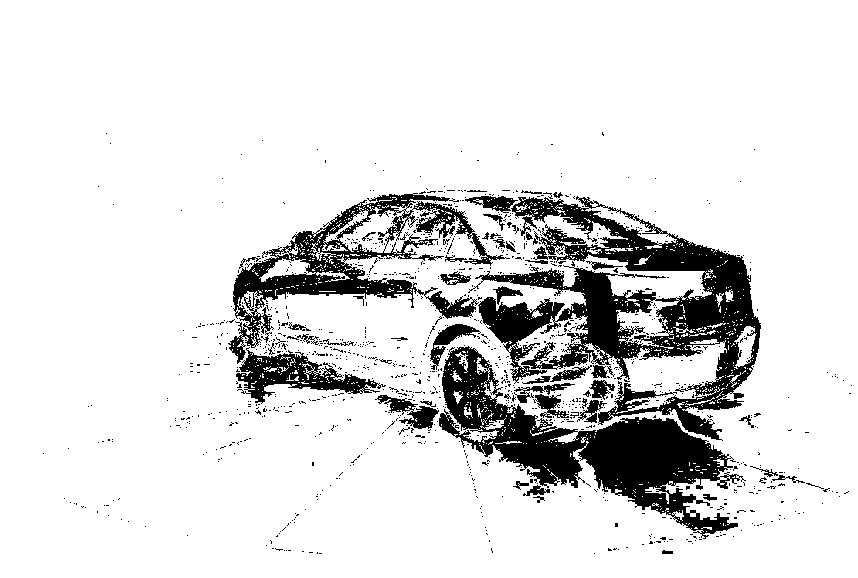

id: 36a3f7f77e85_08


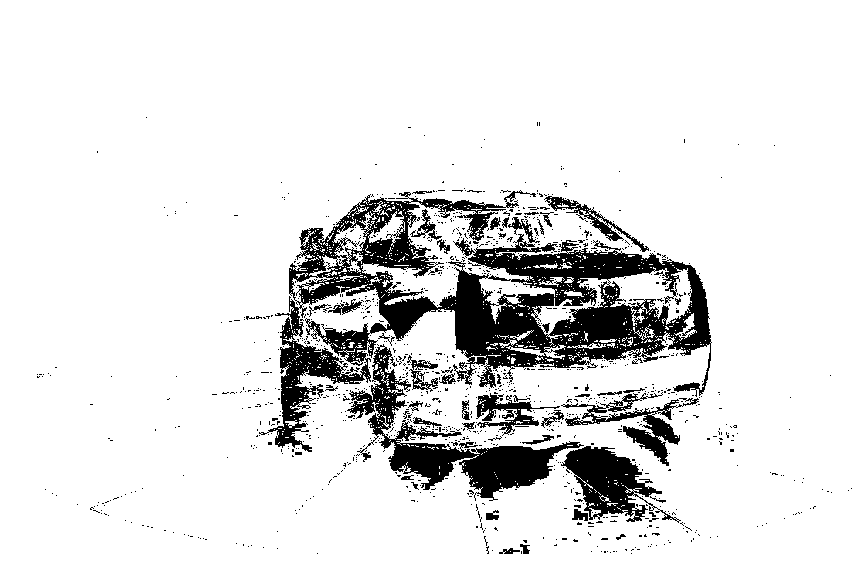

id: 36a3f7f77e85_09


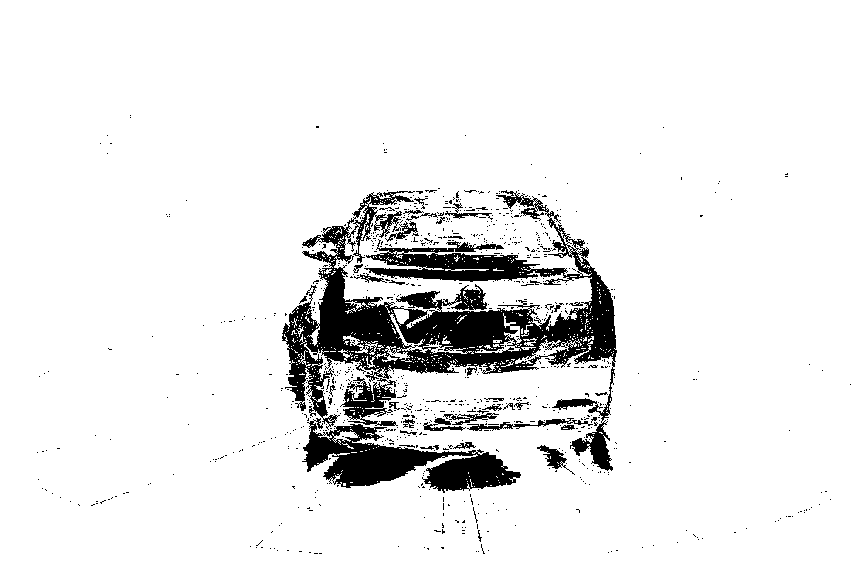

id: 36a3f7f77e85_10


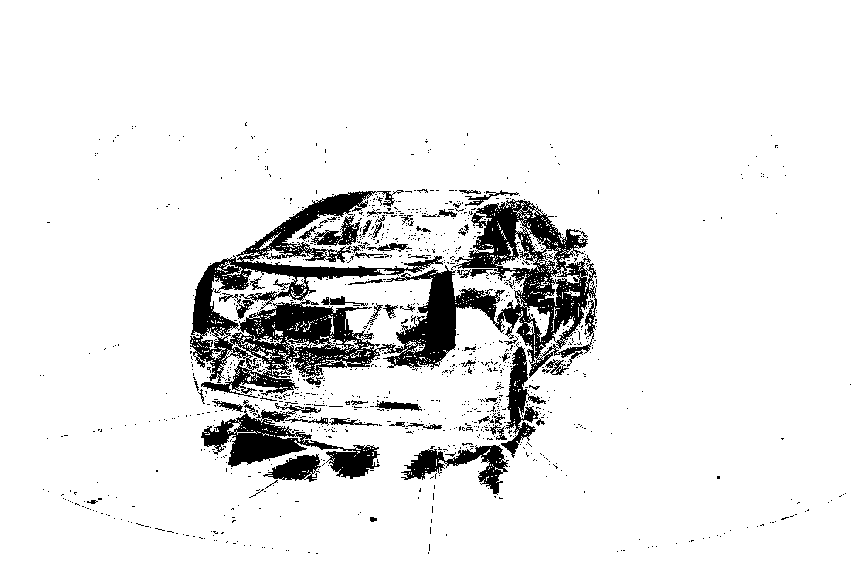

id: 36a3f7f77e85_11


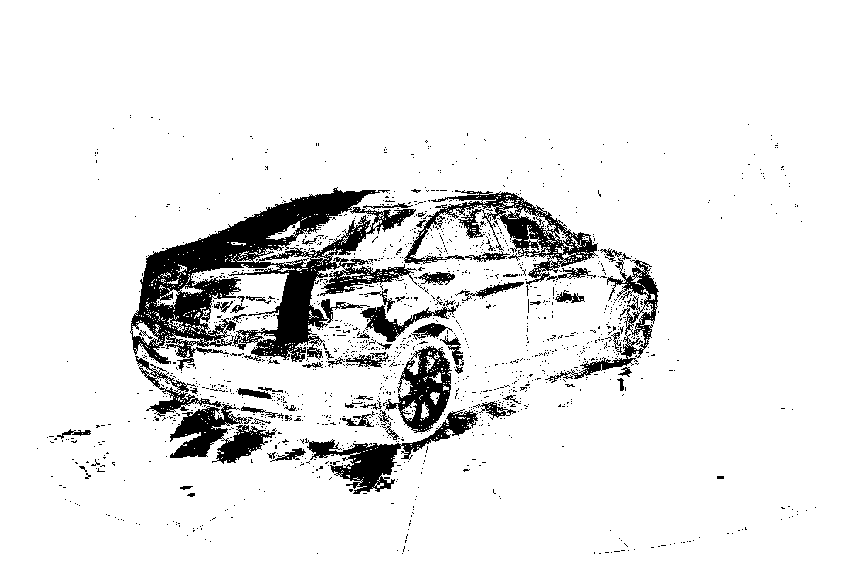

id: 36a3f7f77e85_12


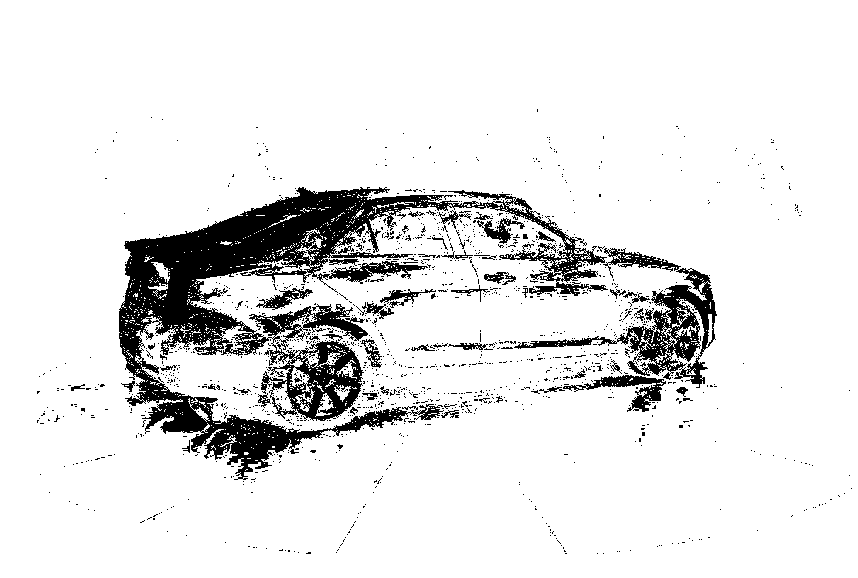

id: 36a3f7f77e85_13


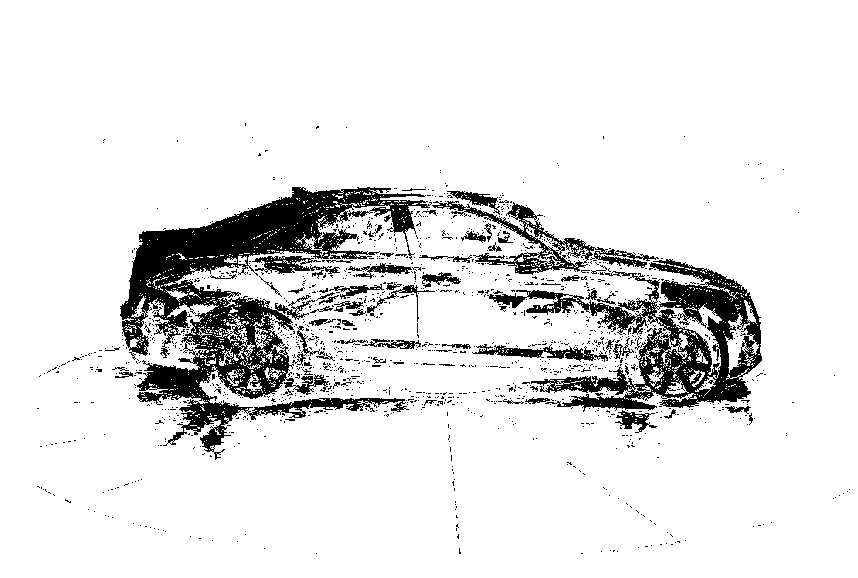

In [0]:
img_id = '36a3f7f77e85'

fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

for i in range(1,14):
    _id = "%02d" % (i,)
    curr_id = img_id+'_'+_id
    print('id:', curr_id)
    frame = get_img(curr_id)
    fgmask = fgbg.apply(frame)
    plt.figure(figsize=(20,10))
    plt.imshow(fgmask)
    plt.axis('off')
    plt.show()
    
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
    
# cap.release()
# cv2.destroyAllWindows()

In [0]:
def get_img_id(img_path):
    return img_path[:15]

img_ids = list(map(get_img_id, list(train_masks_df.img.values)))

def load_image_disk(img_id, folder=TRAIN_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".jpg"))
    return img

def get_image(img_id):
    #return train_imgs[img_id]
    return cv2.resize(load_image_disk(img_id), (new_shape[0], new_shape[1]))
  
# Return mask as 1/0 binary img with single channel
def load_mask_disk(img_id, folder=TRAIN_MASKS_PATH, filetype='gif'):
    mask = misc.imread(os.path.join(folder,  "{}_mask.{}".format(img_id, filetype)), flatten=True)
    mask[mask > 128] = 1
    if len(mask.shape) == 2:
        mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
    return mask

def get_mask(img_id):   
    #return train_masks[img_id]
    return np.expand_dims(cv2.resize(load_mask_disk(img_id), (new_shape[0], new_shape[1])), axis=2)

In [0]:
'''# Read training images into memory
train_imgs = {}
for img_path in tqdm(os.listdir(TRAIN_PATH)):
    img_id = get_img_id(img_path)
    train_imgs[img_id] = cv2.resize(load_image_disk(img_id), (new_shape[0], new_shape[1]))
'''

'# Read training images into memory\ntrain_imgs = {}\nfor img_path in tqdm(os.listdir(TRAIN_PATH)):\n    img_id = get_img_id(img_path)\n    train_imgs[img_id] = cv2.resize(load_image_disk(img_id), (new_shape[0], new_shape[1]))\n'

In [0]:
'''
# Read training masks into memory
train_masks = {}
for img_path in tqdm(os.listdir(TRAIN_MASKS_PATH)):
    img_id = get_img_id(img_path)
    train_masks[img_id] = np.expand_dims(cv2.resize(load_mask_disk(img_id), (new_shape[0], new_shape[1])), axis=2)
'''

'\n# Read training masks into memory\ntrain_masks = {}\nfor img_path in tqdm(os.listdir(TRAIN_MASKS_PATH)):\n    img_id = get_img_id(img_path)\n    train_masks[img_id] = np.expand_dims(cv2.resize(load_mask_disk(img_id), (new_shape[0], new_shape[1])), axis=2)\n'

In [0]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_REFLECT_101, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape
        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(0, 0, 0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(0, 0, 0,))
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=2)

    return image, mask

def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

In [0]:
def generate_training_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            x, y = randomShiftScaleRotate(x, y,
                                          shift_limit=(-0.0625, 0.0625),
                                          scale_limit=(-0.1, 0.1),
                                          rotate_limit=(-0, 0))
#             x = randomHueSaturationValue(x,
#                                hue_shift_limit=(-50, 50),
#                                sat_shift_limit=(-5, 5),
#                                val_shift_limit=(-15, 15))
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

def generate_validation_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y
        
def generate_validation_data_seq(data):
    idx = 0
    while True:
        img_id = data[idx]
        X = get_image(img_id)
        Y = get_mask(img_id)
        yield img_id, X, Y
        idx  += 1
        if idx >= len(data):
            break

def get_model_memory_usage(batch_size, model):
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

    total_memory = 4*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = round(total_memory / (1024 ** 3), 3)
    mbytes = round(total_memory / (1024 ** 2), 3)
    
    print('trainable_count', trainable_count, 'non_trainable_count', non_trainable_count, 'gbytes', gbytes, 'mbytes', mbytes)     


In [0]:
'''random_idx = np.random.randint(len(train_imgs.keys()))
random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
temp_img = get_image(random_img_id)
mask = get_mask(random_img_id)
temp_img, temp_mask = randomShiftScaleRotate(temp_img, mask,
                              shift_limit=(-0.0625, 0.0625),
                              scale_limit=(-0.1, 0.1),
                              rotate_limit=(-0, 0))

plt.imshow(temp_img * gray2rgb(temp_mask))
plt.axis('off')
plt.show()
'''

"random_idx = np.random.randint(len(train_imgs.keys()))\nrandom_img_id = list(train_imgs.keys())[random_idx]\nplot_image(random_img_id)\ntemp_img = get_image(random_img_id)\nmask = get_mask(random_img_id)\ntemp_img, temp_mask = randomShiftScaleRotate(temp_img, mask,\n                              shift_limit=(-0.0625, 0.0625),\n                              scale_limit=(-0.1, 0.1),\n                              rotate_limit=(-0, 0))\n\nplt.imshow(temp_img * gray2rgb(temp_mask))\nplt.axis('off')\nplt.show()\n"

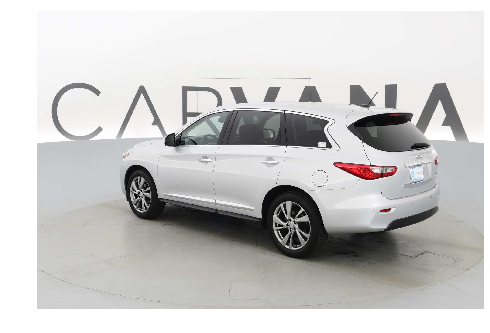

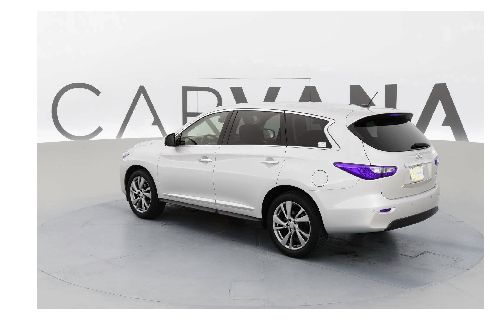

In [0]:
# Visualize impact of random hue saturation
# random_idx = np.random.randint(len(train_imgs.keys()))
# random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
temp_img = cv2.imread(os.path.join(TRAIN_PATH, '{}.jpg'.format(random_img_id)))
temp_img = randomHueSaturationValue(temp_img,
                               hue_shift_limit=(-50, 50),
                               sat_shift_limit=(-5, 5),
                               val_shift_limit=(-15, 15))
plt.imshow(temp_img)
plt.axis('off')
plt.show()

In [0]:
def sharpen(img):
    #face = misc.face(gray=True).astype(float)
    blurred_f = ndimage.gaussian_filter(img, 3)
    filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    alpha = 30
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    return sharpened

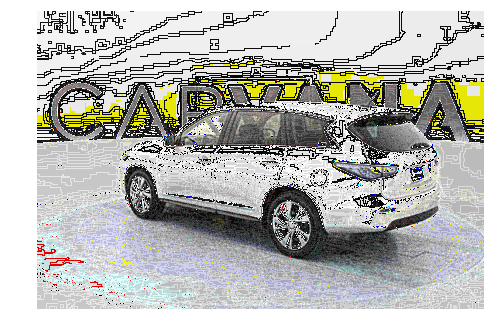

In [0]:
plt.imshow(sharpen(temp_img))
plt.axis('off')
plt.show()

In [0]:
def down(filters,input_,pool=True):
    global droprate
    temp_ = BatchNormalization(epsilon=1e-4)(input_)
    temp_conv = Conv2D(filters,(3,3),activation='relu',padding='same')(temp_)
    temp_conv = Conv2D(filters,(3,3),activation='relu',padding='same')(temp_conv)
    if pool:
      down_pool = MaxPooling2D((2,2))(temp_conv)
    else:
      down_pool = temp_conv
    down_pool = Dropout(droprate)(down_pool)
    return down_pool,temp_conv
    
def up(filters, input_, temp_conv,drop=True,upconv=True):
  global droprate
  if upconv:
    #print(type(input_))
    input1 = Conv2DTranspose(filters,(2,2),strides=(2,2),padding='same')(input_)
    temp_ = concatenate([input1,temp_conv]) 
  else:
    temp_ = concatenate([UpSampling2D(size=(2,2))(input_),temp_conv])

  temp_ = BatchNormalization(epsilon=1e-4)(temp_)
  conv = Conv2D(filters, (3, 3),activation='relu', padding='same')(temp_)
  conv = Conv2D(filters, (3, 3),activation='relu', padding='same')(conv)
  if drop:
    conv = Dropout(droprate)(conv)
  return conv

In [0]:
def unet_deeper(input_shape=(HEIGHT, WIDTH, CHANNELS), num_classes=1):
    inputs = Input(shape=input_shape)
    global droprate
    droprate = 0.25
    filters = 32
    growth = 2
    upconv = True
    with tf.device('/gpu:0'):
        
        pool1,conv1 = down(filters, inputs)
        filters *= growth
        pool2,conv2 = down(filters, pool1)
        filters *= growth
        pool3,conv3 = down(filters, pool2)
        filters *= growth
        pool4_0,conv4_0 = down(filters, pool3)
        filters *= growth
        pool4_1,conv4_1 = down(filters, pool4_0)
        filters *= growth
        pool4_2,conv4_2 = down(filters, pool4_1)
        filters *= growth
        pool4_3,conv5 = down(filters,pool4_2,False)

        
    with tf.device('/gpu:1'):
        filters //=growth
        conv6 = up(filters,conv5,conv4_2)
        filters //=growth
        conv6_1 = up(filters,conv6,conv4_1)
        filters //=growth
        conv6_2 = up(filters,conv6_1,conv4_0)
        filters //=growth
        conv7 = up(filters,conv6_2,conv3)
        filters //=growth
        conv8 = up(filters,conv7,conv2)
        filters //=growth
        conv9 = up(filters,conv8,conv1,drop=False)
        
    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [0]:
BATCH_SIZE = 2

In [0]:
# Training new model
ts = str(int(time.time()))
model_name = 'trial'
num_epochs = 2
steps_per_epoch = int(len(img_ids) * 0.8/BATCH_SIZE)
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join('./', run_name)
checkpoint_loc = os.path.join('./', 'model-{}-weights.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping, tensorboard]

model = unet_deeper()
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
get_model_memory_usage(BATCH_SIZE, model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 512, 512, 3)  12          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 512, 512, 32) 896         batch_normalization_14[0][0]     
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [0]:
!ls

 29bb3ece3180_11.jpg
'kaggle (1).json'
 kaggle.json
 metadata.csv
 metadata.csv.zip
 model-1546239658-weights.h5
'model=trial-batch_size=2-num_epoch=5-steps_per_epoch=2035-ts=1546239658'
 sample_data
 sample_submission.csv
 sample_submission.csv.zip
 test
 test_hq
 test_hq.zip
 test.zip
 train
 train_hq
 train_hq.zip
 train_masks
 train_masks.csv
 train_masks.csv.zip
 train_masks.zip
 train.zip


In [0]:
train_ids, validation_ids = model_selection.train_test_split(img_ids, random_state=42, test_size=0.20)
train_generator = generate_training_batch(train_ids, BATCH_SIZE)
valid_generator = generate_validation_batch(validation_ids, BATCH_SIZE)
VALIDATION_STEPS = int(len(validation_ids) / BATCH_SIZE)

print('Starting run {}'.format(run_name))
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = VALIDATION_STEPS)

Starting run model=trial-batch_size=2-num_epoch=2-steps_per_epoch=2035-ts=1546243541
Epoch 1/2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


2035/2035 [==============================] - 1778s 874ms/step - loss: 0.0766 - dice_coef: 0.9599 - val_loss: 0.0829 - val_dice_coef: 0.9665

Epoch 00001: val_loss improved from inf to 0.08285, saving model to ./model-1546243541-weights.h5
Epoch 2/2
2035/2035 [==============================] - 1765s 867ms/step - loss: 0.0292 - dice_coef: 0.9854 - val_loss: 0.0395 - val_dice_coef: 0.9816

Epoch 00002: val_loss improved from 0.08285 to 0.03949, saving model to ./model-1546243541-weights.h5


In [0]:
model_path = os.path.join('./', 'model-{}.h5'.format(ts))
history_path = os.path.join('./', 'model-{}.history'.format(ts))
model.save(model_path)
pickle.dump(history.history, open(history_path, "wb"))
print('Saved model at {}'.format(model_path))
print('Saved model history at {}'.format(history_path))

Saved model at ./model-1546243541.h5
Saved model history at ./model-1546243541.history


In [0]:
!ls

 29bb3ece3180_11.jpg
'kaggle (1).json'
 kaggle.json
 metadata.csv
 metadata.csv.zip
 model-1546239658-weights.h5
 model-1546243541.h5
 model-1546243541.history
 model-1546243541-weights.h5
'model=trial-batch_size=2-num_epoch=2-steps_per_epoch=2035-ts=1546243541'
'model=trial-batch_size=2-num_epoch=5-steps_per_epoch=2035-ts=1546239658'
 sample_data
 sample_submission.csv
 sample_submission.csv.zip
 test
 test_hq
 test_hq.zip
 test.zip
 train
 train_hq
 train_hq.zip
 train_masks
 train_masks.csv
 train_masks.csv.zip
 train_masks.zip
 train.zip


In [0]:
from google.colab import files
files.download('model-1546243541.h5') 


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 43718, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
from google.colab import files
uploaded = files.upload()

Saving model-1546243541.h5 to model-1546243541 (1).h5


KeyboardInterrupt: ignored

In [0]:
model = load_model(os.path.join('./', 'model-1546243541.h5'), custom_objects={'dice_coef': dice_coef,'bce_dice_loss':bce_dice_loss})

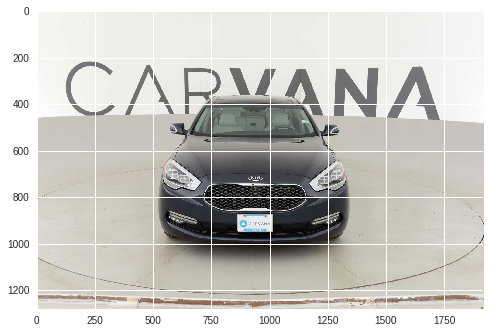

In [0]:
plt.imshow(get_img('8d1a6723c458_01'))

mask id: 8d1a6723c458_01


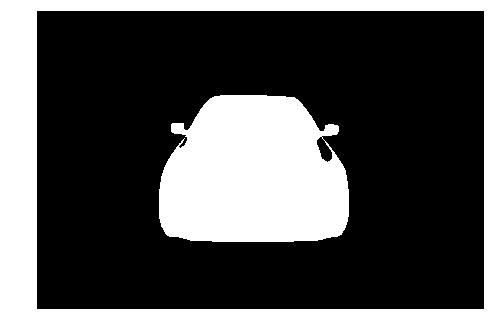

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


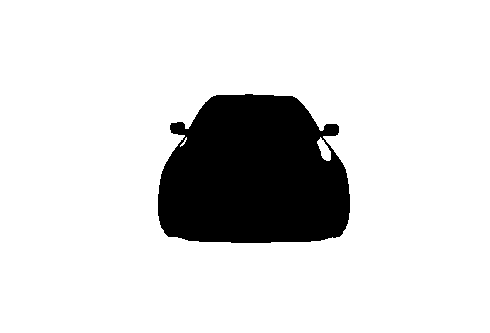

In [0]:
check_mask('8d1a6723c458_01')

In [0]:
img = get_image('8d1a6723c458_01')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


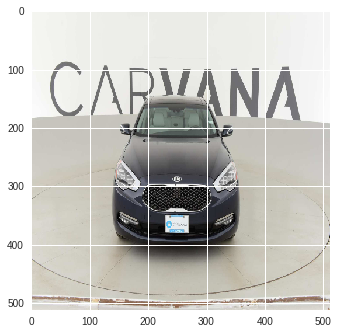

In [0]:
plt.imshow(img)

In [0]:
pred_mask = model.predict(np.expand_dims(img,axis=0))

In [0]:
pred_mask = np.squeeze(pred_mask)    
pred_mask = resize_img(pred_mask, (HEIGHT_ORIG, WIDTH_ORIG))
pred_mask[pred_mask <= 0.5] = 0
pred_mask[pred_mask > 0.5] = 1

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


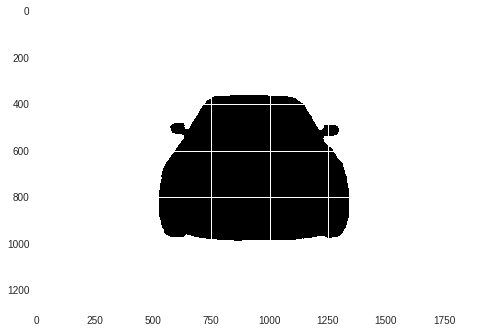

In [0]:
plt.imshow(pred_mask)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


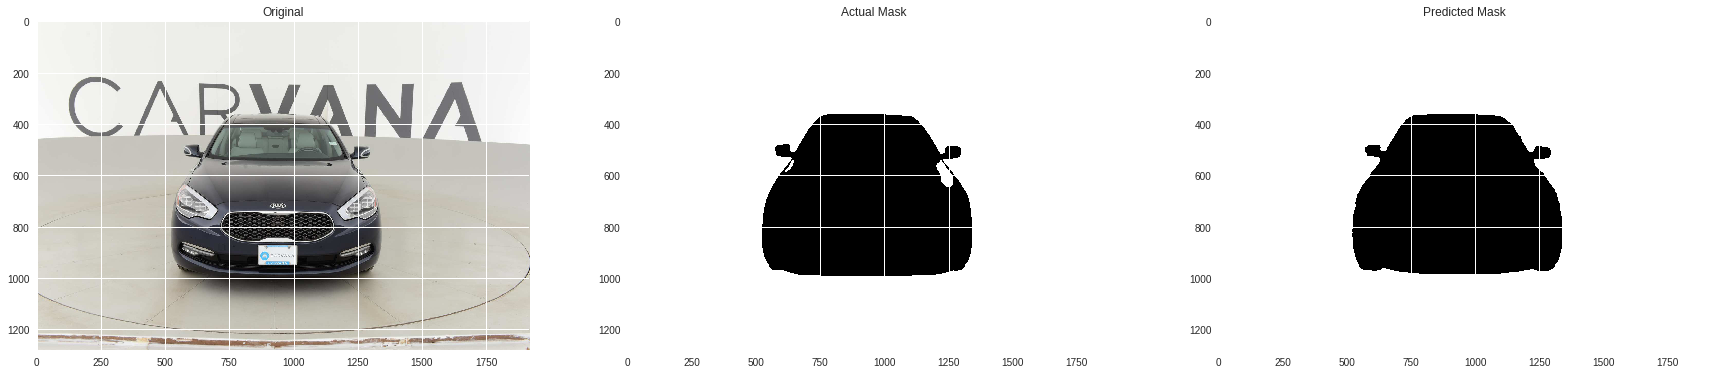

In [0]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(30,10)
ax[0].imshow(get_img('8d1a6723c458_01'))
ax[0].set_title('Original')
ax[1].imshow(np.squeeze(get_mask_inner('8d1a6723c458_01',1)))
ax[1].set_title('Actual Mask')
ax[2].imshow(pred_mask)
ax[2].set_title('Predicted Mask')
print()